Today's topics:

- how to manage models after they are built
    - storing
    - updating
- tips for the gene project
- data storage APIs

In [7]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [11]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', ';')

In [12]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


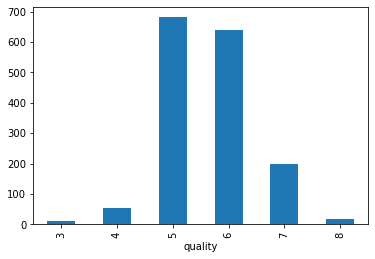

In [15]:
df.groupby('quality').size().plot(kind='bar')

In [16]:
labels = df.pop('quality') # removes the quality column in this temp df

In [18]:
Xtr, Xte, ytr, yte = train_test_split(df, labels, test_size=0.3) # model will vary from each run bc no seed is set. for reproducible, set seed here.

In [19]:
depth, min_leaf= 3, 10

In [22]:
import mlflow
import mlflow.sklearn

In [23]:
# pip install mlflow

In [28]:
mlflow.set_registry_uri('sqlite:///models.db')

In [29]:
with mlflow.start_run(run_name='tree_run'):
    model = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=min_leaf)
    model.fit(Xtr, ytr)
    mlflow.log_params({
        'depth': depth,
        'min_leaf': min_leaf
    })
    predictions = model.predict(Xte)
    mlflow.log_metrics({
        'r_squared': r2_score(yte, predictions),
        'mse': mean_squared_error(yte, predictions)
    })
    mlflow.sklearn.log_model(model, 'model', registered_model_name='decision_tree_model')

Successfully registered model 'decision_tree_model'.
2020/11/12 10:31:39 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: decision_tree_model, version 1
Created version '1' of model 'decision_tree_model'.


In [30]:
! mlflow server

^C


Open address [http://127.0.0.1:5000/#/](http://127.0.0.1:5000/#/)

# Eliminating some Python class boilerplate

In [32]:
import attr

In [34]:
# what we have been doing up to now
class MyBankerOld:
    def __init__(self, model, interest=0.05):
        self.model = model
        self.interest = interest

In [37]:
# with attr we use decorators

@attr.s
class MyBanker:
    model = attr.ib()
    interst = attr.ib(default=0.05)

In [38]:
MyBanker(None)

MyBanker(model=None, interst=0.05)

In [39]:
MyBanker()

TypeError: __init__() missing 1 required positional argument: 'model'

This is very powerful since you can also give it a function to use in the class. 
(In other words, read up on `attr`)

# Testing

In [40]:
@attr.s
class MyBanker:
    model = attr.ib()
    interst = attr.ib(default=0.05)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self

In [42]:
import unittest
import unittest.mock

In [46]:
class MyBankerTest(unittest.TestCase):
    def test_fit(self):
        mock_model = unittest.mock.Mock()
        banker = MyBanker(mock_model)
        banker.fit('X', 'y')
        mock_model.fit.assert_called_with('X', 'y')  # intended error


In [47]:
unittest.main(argv=[''], exit=False)  # argv arg of sprict but none are running, exit=False means please dont quit after finished

E
ERROR: test_fit (__main__.MyBankerTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-46-f91023f1eda0>", line 5, in test_fit
    banker.fit('X', 'y')
AttributeError: 'MyBanker' object has no attribute 'fit'

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (errors=1)


There's somehting wrong in my code. This isn't the error I was supposed to be getting here. It supposed to tell me that fit was wrongly called. 

More on these topics are _'Clean Code'_ and _'The clean Coder'_ by Robert Martin

# Command line arguments with `argparse`

We want to be able to call our script like so:
`test_lending.py --interest 0.05  --model tree` 

In [48]:
import argparse

In [49]:
parse = argparse.ArgumentParser(description='One line description of my program.')

In [50]:
# Normally:
# if __name__=='__main__':
#     parser.parse_args()

In [54]:
try:
    print(parse.parse_args(['-h']))
except:
    print('passing')
    pass

usage: ipykernel_launcher.py [-h]

One line description of my program.

optional arguments:
  -h, --help  show this help message and exit
passing


In [56]:
parse.add_argument('--interest', default=0.05, type=float)

_StoreAction(option_strings=['--interest'], dest='interest', nargs=None, const=None, default=0.05, type=<class 'float'>, choices=None, help=None, metavar=None)

In [58]:
parse.parse_args(['--interest', '0.05'])

Namespace(interest=0.05)

# Creating a model

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
@attr.s
class MyBanker:
    
    model = attr.ib(factory=LogisticRegression)

In [61]:
MyBanker()

MyBanker(model=LogisticRegression())

In [62]:
def model_factory(model_name, **args):
    if model_name == 'logistic':
        return LogisticRegression(**args)
   

In [63]:
model_factory('logistic', C=0.5)

LogisticRegression(C=0.5)

In [65]:
model_factory('lotic', C=0.5)  # will return nothing since there is no know model name given

In [72]:
def model_factory(model_name, **args):
    classes = {'logistic': LogisticRegression}
    model_class = classes.get(model_name)
    if model_class:
        return model_class(**args)
    else:
        raise NotImplementedError(f"Model class {model_name} unknown\n"
                                 f"Possible models are {classes.keys()}.")

In [73]:
model_factory('logistic', C=0.5)

LogisticRegression(C=0.5)

In [74]:
model_factory('lotic', C=0.5)  # 

NotImplementedError: Model class lotic unknown
Possible models are dict_keys(['logistic']).

Nice! Much better than building pipline like i had to for GridSearch

# YAML 
Using configuration file and generalized scripts for flexibity

In [75]:
import yaml

In [76]:
yaml.full_load("""
params:
    C: 0.75
    interest: 0.06
list: [1, 2, 3]
other_list:
   - this 
   - is
   - a
   - list
""")

{'params': {'C': 0.75, 'interest': 0.06},
 'list': [1, 2, 3],
 'other_list': ['this', 'is', 'a', 'list']}

Wow!

In [79]:
@attr.s
class Evaluator(yaml.YAMLObject):
    
    yaml_tag = u"!Evaluator"
    
    interest = attr.ib()
    folds = attr.ib()

In [80]:
yaml.full_load("""
- !Evaluator
    interest: 0.06
    folds: 10
""")

[Evaluator(interest=0.06, folds=10)]

In [82]:
attr.asdict(Evaluator(0.03, 5))

{'interest': 0.03, 'folds': 5}

This makes it easier if you want to save these model configurations for later use. 

In [83]:
# JSON quick intro

In [84]:
import json

In [85]:
d = attr.asdict(Evaluator(0.03, 5))

In [86]:
print(json.dumps(d, indent=2))

{
  "interest": 0.03,
  "folds": 5
}


In [87]:
json.loads('{"a": [1,2,3]}')

{'a': [1, 2, 3]}

# tinydb
Store data as json files

In [90]:
import tinydb

In [92]:
db = tinydb.TinyDB('myfirsttinydb.json')

In [97]:
db.insert({'name': {'last': 'Lennon', 'first': 'John'}, 'born':1940, 'band': 'Beatles, The'})

2

In [94]:
Artist = tinydb.Query()

In [98]:
db.search(Artist.band == 'Beatles, The')

[{'name': {'last': 'Lennon', 'first': 'John'},
  'born': 1940,
  'band': 'Beatles, The'}]

In [99]:
db.contains(Artist.band == 'Beatles, The')

True

In [100]:
db.count(Artist.band == 'Beatles, The')

1

In [101]:
db.update({'name': {'last':'Lennon', 'middle':'Winston', 'first':'John'}},
         Artist.name.last== 'Lennon')

[1, 2]

In [102]:
db.search(Artist.band== 'Beatles, The')

[{'name': {'last': 'Lennon', 'middle': 'Winston', 'first': 'John'},
  'born': 1940,
  'band': 'Beatles, The'}]

Follows the NoSQL rules, where anything can be inserted into the database. Provide flexibility that SQL cannot probvide. But can be problematic when mulitple customers are accessing/updating the same info

# Twitter
Need to set up API with current account.

In [104]:
import requests
from requests_oauthlib import OAuth1

In [107]:
# import configurations form some python/json/other file in your repo. Make sure to keep this private!
API_KEY, API_KEY_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET = '','','',''

In [108]:
auth = OAuth1(API_KEY, API_KEY_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

In [109]:
url = 'http://www.twitter.com/1.1/account/verify_credentials.json'

In [111]:
verify_response = requests.get(url, auth=auth)

In [112]:
verify_response

<Response [200]>

In [113]:
verify_response.headers

{'cache-control': 'no-cache, no-store, must-revalidate, pre-check=0, post-check=0', 'content-encoding': 'gzip', 'content-security-policy': "connect-src 'self' blob: https://*.giphy.com https://*.pscp.tv https://*.video.pscp.tv https://*.twimg.com https://api.twitter.com https://api-stream.twitter.com https://ads-api.twitter.com https://caps.twitter.com https://media.riffsy.com https://pay.twitter.com https://sentry.io https://ton.twitter.com https://twitter.com https://upload.twitter.com https://www.google-analytics.com https://app.link https://api2.branch.io https://bnc.lt https://vmap.snappytv.com https://vmapstage.snappytv.com https://vmaprel.snappytv.com https://vmap.grabyo.com https://dhdsnappytv-vh.akamaihd.net https://pdhdsnappytv-vh.akamaihd.net https://mdhdsnappytv-vh.akamaihd.net https://mdhdsnappytv-vh.akamaihd.net https://mpdhdsnappytv-vh.akamaihd.net https://mmdhdsnappytv-vh.akamaihd.net https://mdhdsnappytv-vh.akamaihd.net https://mpdhdsnappytv-vh.akamaihd.net https://mmd

In [114]:
verify_response.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)